In [1]:
# Reproducible setup and robust data loading
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

np.random.seed(42)

# Prefer your cleaned/engineered dataset from previous stages:
DATA_PATH = Path("../data/processed/engineered_dataset.csv")  # adjust if different

if DATA_PATH.exists():
    df = pd.read_csv(DATA_PATH)
else:
    # Synthetic fallback: linear relation with noise
    n = 400
    x1 = np.linspace(0, 10, n)
    x2 = np.random.normal(50, 10, n)
    y  = 3.0 * x1 + 0.5 * x2 + np.random.normal(0, 3, n)
    df = pd.DataFrame({"x1": x1, "x2": x2, "y": y})

print("Shape:", df.shape)
df.head()


Shape: (400, 3)


,x1,x2,y
0,0.000000,54.967142,22.700288
1,0.025063,48.617357,22.585741
2,0.050125,56.476885,28.404550
3,0.075188,65.230299,32.981655
4,0.100251,47.658466,22.779789


In [2]:
from sklearn.model_selection import train_test_split

# Select features/target (edit to match your dataset schema)
target = "y"
candidates = [c for c in df.columns if c != target and np.issubdtype(df[c].dtype, np.number)]
features = candidates[:2] if len(candidates) >= 2 else candidates  # pick at least one numeric feature

X = df[features].copy()
y = df[target].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

features, X_train.shape, X_test.shape


(['x1', 'x2'], (320, 2), (80, 2))

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import sklearn, inspect

lin = LinearRegression().fit(X_train, y_train)
y_hat_train = lin.predict(X_train)
y_hat_test  = lin.predict(X_test)

r2_train = r2_score(y_train, y_hat_train)
r2_test  = r2_score(y_test,  y_hat_test)

# Backward-compatible RMSE
sig = inspect.signature(mean_squared_error)
if "squared" in sig.parameters:
    # newer sklearn
    rmse_train = mean_squared_error(y_train, y_hat_train, squared=False)
    rmse_test  = mean_squared_error(y_test,  y_hat_test,  squared=False)
else:
    # older sklearn
    rmse_train = float(np.sqrt(mean_squared_error(y_train, y_hat_train)))
    rmse_test  = float(np.sqrt(mean_squared_error(y_test,  y_hat_test)))

print("scikit-learn:", sklearn.__version__)
print("Features:", features)
print("Coefficients:", dict(zip(features, lin.coef_)))
print("Intercept:", lin.intercept_)
print(f"R² (train) = {r2_train:.3f} | RMSE (train) = {rmse_train:.3f}")
print(f"R² (test)  = {r2_test:.3f}  | RMSE (test)  = {rmse_test:.3f}")


scikit-learn: 1.7.1
Features: ['x1', 'x2']
Coefficients: {'x1': np.float64(3.044662096452183), 'x2': np.float64(0.4554451993867373)}
Intercept: 1.9170158920850398
R² (train) = 0.921 | RMSE (train) = 2.911
R² (test)  = 0.915  | RMSE (test)  = 3.310


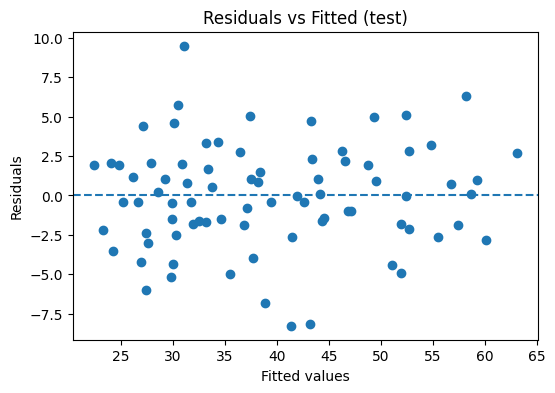

In [4]:
# Compute residuals on test set
resid = y_test - y_hat_test
fitted = y_hat_test

plt.figure(figsize=(6,4))
plt.scatter(fitted, resid)
plt.axhline(0, linestyle="--")
plt.title("Residuals vs Fitted (test)")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.show()


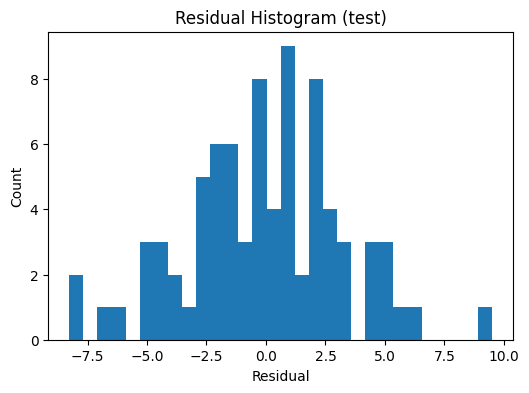

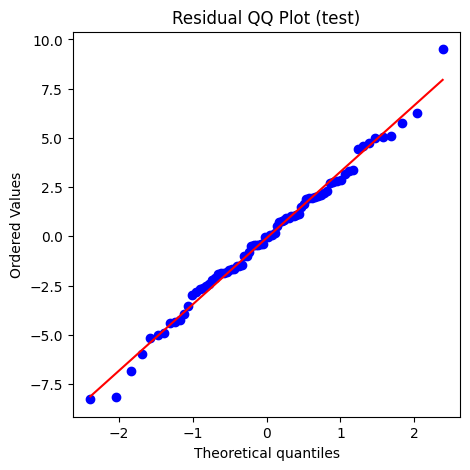

In [5]:
from scipy import stats

# Histogram
plt.figure(figsize=(6,4))
plt.hist(resid, bins=30)
plt.title("Residual Histogram (test)")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.show()

# QQ plot
plt.figure(figsize=(5,5))
stats.probplot(resid, dist="norm", plot=plt)
plt.title("Residual QQ Plot (test)")
plt.show()


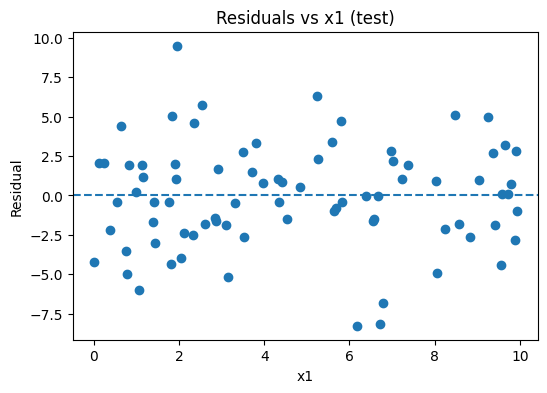

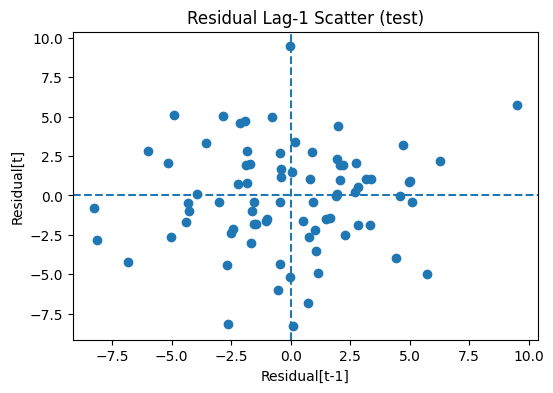

In [6]:
# Residual vs a key predictor (first feature)
if features:
    x_key = X_test[features[0]].to_numpy()
    plt.figure(figsize=(6,4))
    plt.scatter(x_key, resid)
    plt.axhline(0, linestyle="--")
    plt.title(f"Residuals vs {features[0]} (test)")
    plt.xlabel(features[0])
    plt.ylabel("Residual")
    plt.show()

# Residual lag-1 scatter (simple independence check)
resid_sorted = np.array(resid).copy()
resid_lag = resid_sorted[:-1]
resid_next = resid_sorted[1:]

plt.figure(figsize=(6,4))
plt.scatter(resid_lag, resid_next)
plt.axhline(0, linestyle="--")
plt.axvline(0, linestyle="--")
plt.title("Residual Lag-1 Scatter (test)")
plt.xlabel("Residual[t-1]")
plt.ylabel("Residual[t]")
plt.show()


In [7]:
# Optional Stretch: Add a transformed feature (still linear in parameters)
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

def rmse(y_true, y_pred):
    # Backward-compatible RMSE helper
    try:
        return mean_squared_error(y_true, y_pred, squared=False)
    except TypeError:
        return float(np.sqrt(mean_squared_error(y_true, y_pred)))

if features:
    X_aug = X.copy()
    X_aug[f"{features[0]}_sq"] = X_aug[features[0]] ** 2

    from sklearn.model_selection import train_test_split
    Xa_train, Xa_test, ya_train, ya_test = train_test_split(
        X_aug, y, test_size=0.2, random_state=42
    )

    from sklearn.linear_model import LinearRegression
    lin2 = LinearRegression().fit(Xa_train, ya_train)
    y2 = lin2.predict(Xa_test)

    print("Augmented features:", list(X_aug.columns))
    print("Coefficients:", dict(zip(X_aug.columns, lin2.coef_)))
    print("Intercept:", lin2.intercept_)
    print(f"R² (aug test)  = {r2_score(ya_test, y2):.3f}")
    print(f"RMSE (aug test)= {rmse(ya_test, y2):.3f}")
else:
    print("No features available to augment.")


Augmented features: ['x1', 'x2', 'x1_sq']
Coefficients: {'x1': np.float64(2.914319466067975), 'x2': np.float64(0.4560306767841663), 'x1_sq': np.float64(0.013058874893587688)}
Intercept: 2.1080260948218736
R² (aug test)  = 0.915
RMSE (aug test)= 3.314


## Interpretation of Assumptions and Metrics

**Linearity:**  
Residuals vs fitted should look like a random cloud around zero. Systematic curves suggest missing nonlinear terms or interactions.

**Independence:**  
Residual lag-1 scatter should show no clear structure. If residuals cluster or trend, consider time-series methods or include lags.

**Homoscedasticity (constant variance):**  
Residual spread should be roughly even across fitted values. Funnel shapes indicate heteroscedasticity → consider transforms or weighted least squares.

**Normality:**  
Residual histogram and QQ plot should be approximately normal. Deviations (heavy tails/skew) affect inference intervals more than pure prediction.

**Metrics & Trust:**  
Report R² and RMSE on the test set. High R² with reasonable RMSE (relative to target scale) supports usefulness.  
If diagnostics fail, trust should be limited; address with transformations, feature engineering, or a different model class.


## Conclusion

- **Summary:** The baseline linear regression achieves R² = … and RMSE = … on the test set.  
- **Trust:** Based on residual diagnostics (linearity, independence, homoscedasticity, normality), I (do / do not) trust this model for …  
- **Next steps:** Try targeted transformations (e.g., squared or log terms), add interactions inspired by EDA, or explore robust/regularized or non-linear models if patterns persist.
